# Churn Model Tuning
**by David Cochran**<br/>
**Data Analytics @ Newman University**

**Data:** [Churn-Modelling - Kaggle](https://www.kaggle.com/shubh0799/churn-modelling)

**This Notebook:** This is crafted as a demonstration of model tuning, including these key steps:
1. Use K-fold Cross-Validation
2. Prioritize the most important score: accuracy, precision, recall, F1, or ROC-AUC
3. Tune hyperparameters using GridSearchCV
4. Balance imbalanced target classes


**Contents:**
1. Read and Review Data
2. Prepare Data Splits
3. Train Models & Tune Hyperparameters
4. Test & Evaluate Tuned Models

In [1]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from time import time

# Libraries for Machine Learning Process
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Customize seaborn plot styles
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook', font_scale = 0.8)
sns.set_style('ticks')
plt.rc('axes.spines', top=False, right=False, left=False, bottom=False)

# 1. Read and Review Data

This data has been cleaned in a previous EDA and preparation process.

In [3]:
# Read cleaned version of the data
df = pd.read_csv('data/churn_cleaned.csv')
df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,1,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,1,1,43,2,125510.82,1,1,1,79084.10,0
5,645,1,0,44,8,113755.78,2,1,0,149756.71,1
6,822,0,0,50,7,0.00,2,1,1,10062.80,0
7,376,2,1,29,4,115046.74,4,1,0,119346.88,1
8,501,0,0,44,4,142051.07,2,0,1,74940.50,0
9,684,0,0,27,2,134603.88,1,1,1,71725.73,0


In [4]:
# Dataframe fundamental info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  int64  
 2   Gender           10000 non-null  int64  
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 859.5 KB


## Check the distribution of our target classes.

In [5]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [6]:
df['Exited'].value_counts(normalize=True) * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

**Our target classes are imbalanced by approximately 4 to 1.**

The minority class (1) is the value that most interests us.

Thus our models will likely benefit from weighting the minority class to balance the model training process.

These algorithms have a `class_weight` parameter that we can use:
- Logistic Regression
- Decision Tree
- Random Forest

# 2. Prepare Data Splits

In [7]:
# features — all columns except target variable
features = df.drop('Exited', axis=1)

# labels — only the target variable column
labels = df['Exited']

In [8]:
# Create Train and Test Splits
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Report Number and Proportion of Train and Test Features and Labels
print(f'Train Split: {X_train.shape[0]} Records, {len(y_train)} Labels = {round(len(y_train)/len(labels), 4) * 100}%')
print(f'Test Split: {X_test.shape[0]} Records, {len(y_test)} Labels = {round(len(y_test)/len(labels), 4) * 100}%')

Train Split: 8000 Records, 8000 Labels = 80.0%
Test Split: 2000 Records, 2000 Labels = 20.0%


# 3. Train Models and Tune Hyperparameters

- Train models and using cross-validation with GridSearchCV.
- Prioritize Recall score.

In [9]:
# Set up essential elements of a cross-validation process with GridSearchCV 

# Specify random seed value to ensure results are reproducible
# See: https://towardsdatascience.com/how-to-use-random-seeds-effectively-54a4cd855a79
seed = 42

# Set up basic components for training using GridSearch

# Empty list to hold our best models
models_tuned = []

# Scorers we desire during training from GridSearchCV
# zero_division=1 eliminates unnecessary UndefinedMetricWarning see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
scoring = {
            'accuracy': make_scorer(accuracy_score),
            'recall': make_scorer(recall_score),
            'precision': make_scorer(precision_score, zero_division=1),
            'roc_auc': make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=False),
            'f1': make_scorer(f1_score, zero_division=1)
          }

# Metrics that we desire for report of GridSearchCV results
metrics = ['params',
           'mean_test_accuracy',
           'mean_test_precision',
           'mean_test_recall', 
           'mean_test_f1',
           'mean_test_roc_auc'
          ]

# Define function for cross-validation, reporting, and storing top model to models list

def crossval_func(name, algorithm, hparam_grid, priority_score, k):
    cv = GridSearchCV(
                estimator = algorithm,
                param_grid = hparam_grid, 
                scoring = scoring,
                refit = priority_score, 
                cv = k,
                verbose=1
             )

    # Keep track of training time
    start = time()

    # Activate gridsearch
    cv.fit(X_train, y_train)

    end = time()
    latency = round((end-start), 2)

    # Store top model to models list
    model = cv.best_estimator_
    hparams = cv.best_params_
    score = round(cv.best_score_ * 100, 3)
    models_tuned.append({'Name': name, 'Hparams': hparams, 'Model': model, 'Priority': priority_score, 'Score': score})
    
    # Create dataframe from gridsearch cv_results_
    cv_results = pd.DataFrame.from_dict(cv.cv_results_)

    # Specify desired data from our results dataframe
    # cv_results_metrics = cv_results.loc[:, metrics]
    cv_results_metrics = cv_results[metrics].copy()

    #  Sort values and reset index
    sortby = 'mean_test_' + priority_score
    cv_results_metrics.sort_values(sortby, ascending=False, inplace=True)

    # Set new index starting at 1 for sorted dataframe
    cv_results_metrics.index = range(1, cv_results_metrics.shape[0] + 1)

    # Report results
    print(f'\n{name} GRIDSEARCH RESULTS')
    print(f'Priority: {priority_score}')
    print()
    print(f'Training Time: {latency}s')
    print()

    howmany = 9
    print(f'\n{howmany} BEST-PERFORMING {name} MODELS')
    print(f'ranked by {sortby}')
    display(cv_results_metrics.head(howmany))

    print(f'\nTUNED MODEL: {cv.best_estimator_}')
    print(f'\n\t{round(cv.best_score_*100, 3)} {priority_score} score')
    print(f'\n\tSuccessfully added to: models_tuned')

## Logistic Regression

In [10]:
# Specify Algorithm shortname
name = 'LogisticRegression'

# Specify algorithm with desired default hyperparameters
algorithm = LogisticRegression(random_state=seed, fit_intercept=False, max_iter=500, n_jobs=-1)

# Set priority score for selecting best model
priority_score = 'recall'

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'C': [.001, .01, 1, 10, 100, 1000]
}

# Number of folds
k = 5

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

LogisticRegression GRIDSEARCH RESULTS
Priority: recall

Training Time: 4.65s


9 BEST-PERFORMING LogisticRegression MODELS
ranked by mean_test_recall


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
1,{'C': 0.001},0.788375,0.500215,0.046251,0.079936,0.513292
2,{'C': 0.01},0.787875,0.494812,0.046251,0.079714,0.512978
3,{'C': 1},0.787875,0.494812,0.046251,0.079714,0.512978
4,{'C': 10},0.787875,0.494812,0.046251,0.079714,0.512978
5,{'C': 100},0.787875,0.494812,0.046251,0.079714,0.512978
6,{'C': 1000},0.787875,0.494812,0.046251,0.079714,0.512978



TUNED MODEL: LogisticRegression(C=0.001, fit_intercept=False, max_iter=500, n_jobs=-1,
                   random_state=42)

	4.625 recall score

	Successfully added to: models_tuned


## Logistic Regression BALANCED

In [11]:
# Specify Algorithm shortname
name = 'LogisticRegression_BALANCED'

# Specify algorithm with desired default parameters
algorithm = LogisticRegression(class_weight='balanced', random_state=seed, fit_intercept=False, max_iter=500, n_jobs=-1)

# Set priority score: accuracy, precision, recall, f1, or roc_auc
priority_score = 'recall'

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'C': [.001, .01, 1, 10, 100, 1000]
}

# Number of folds
k = 5

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

LogisticRegression_BALANCED GRIDSEARCH RESULTS
Priority: recall

Training Time: 1.47s


9 BEST-PERFORMING LogisticRegression_BALANCED MODELS
ranked by mean_test_recall


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
1,{'C': 0.001},0.655125,0.332751,0.673349,0.445353,0.661880
2,{'C': 0.01},0.654625,0.332356,0.673349,0.444998,0.661565
3,{'C': 1},0.654500,0.332261,0.673349,0.444913,0.661486
4,{'C': 10},0.654500,0.332261,0.673349,0.444913,0.661486
5,{'C': 100},0.654500,0.332261,0.673349,0.444913,0.661486
6,{'C': 1000},0.654500,0.332261,0.673349,0.444913,0.661486



TUNED MODEL: LogisticRegression(C=0.001, class_weight='balanced', fit_intercept=False,
                   max_iter=500, n_jobs=-1, random_state=42)

	67.335 recall score

	Successfully added to: models_tuned


## Decision Tree Classifier

In [12]:
# Specify Algorithm shortname
name = 'DecisionTree'

# Specify algorithm with desired default parameters
algorithm = DecisionTreeClassifier()

# Set priority score: accuracy, precision, recall, f1, or roc_auc
priority_score = 'recall'

# Hyperparameter options for GridSearch to test 
# and identify best hyperparameters combination
hparam_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,5,10],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,3,5]
}

# Number of folds
k = 5

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 54 candidates, totalling 270 fits

DecisionTree GRIDSEARCH RESULTS
Priority: recall

Training Time: 4.76s


9 BEST-PERFORMING DecisionTree MODELS
ranked by mean_test_recall


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
1,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.838500,0.642762,0.488431,0.552917,0.708738
2,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.835375,0.631062,0.485397,0.546862,0.705648
3,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.834750,0.629267,0.483572,0.544895,0.704578
4,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.836875,0.637735,0.482358,0.547175,0.705465
5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.838000,0.642594,0.482358,0.548893,0.706173
6,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.836875,0.638784,0.479926,0.545941,0.704564
7,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.839500,0.651855,0.478710,0.549655,0.705765
8,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.839875,0.652458,0.478703,0.549787,0.705998
9,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.839875,0.653659,0.477495,0.549625,0.705551



TUNED MODEL: DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       min_samples_split=10)

	48.843 recall score

	Successfully added to: models_tuned


## Decision Tree BALANCED

In [13]:
# Specify Algorithm shortname
name = 'DecisionTree_BALANCED'

# Specify algorithm with desired default parameters
algorithm = DecisionTreeClassifier(class_weight='balanced')

# Set priority score: accuracy, precision, recall, f1, or roc_auc
priority_score = 'recall'

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,5,10],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,3,5]
}

# Number of folds
k = 5

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 54 candidates, totalling 270 fits

DecisionTree_BALANCED GRIDSEARCH RESULTS
Priority: recall

Training Time: 5.32s


9 BEST-PERFORMING DecisionTree_BALANCED MODELS
ranked by mean_test_recall


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
1,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.736875,0.424795,0.784052,0.550752,0.754363
2,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.736875,0.424795,0.784052,0.550752,0.754363
3,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.736875,0.424795,0.784052,0.550752,0.754363
4,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.736375,0.424151,0.782836,0.549879,0.753598
5,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.736375,0.424151,0.782836,0.549879,0.753598
6,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.736375,0.424151,0.782836,0.549879,0.753598
7,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.736625,0.424397,0.782834,0.550112,0.753754
8,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.736625,0.424397,0.782834,0.550112,0.753754
9,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.736625,0.424397,0.782834,0.550112,0.753754



TUNED MODEL: DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5)

	78.405 recall score

	Successfully added to: models_tuned


## Random Forest Classifier

In [14]:
# Specify Algorithm shortname
name = 'RandomForest'

# Specify algorithm with desired default parameters
algorithm = RandomForestClassifier()

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'max_depth': [2, 4, 8, 16, 32, None],
    'n_estimators': [5, 50, 250]
}

# Number of folds
k = 5

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

RandomForest GRIDSEARCH RESULTS
Priority: recall

Training Time: 43.45s


9 BEST-PERFORMING RandomForest MODELS
ranked by mean_test_recall


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
1,"{'max_depth': None, 'n_estimators': 250}",0.862625,0.769901,0.475664,0.586462,0.719188
2,"{'max_depth': 16, 'n_estimators': 250}",0.862750,0.772265,0.474446,0.586365,0.718815
3,"{'max_depth': 16, 'n_estimators': 5}",0.844625,0.675868,0.473818,0.555150,0.707172
4,"{'max_depth': 32, 'n_estimators': 5}",0.837875,0.646010,0.473219,0.544956,0.702703
5,"{'max_depth': 32, 'n_estimators': 250}",0.860250,0.760307,0.470194,0.579540,0.715666
6,"{'max_depth': None, 'n_estimators': 5}",0.839500,0.653660,0.470192,0.545618,0.702607
7,"{'max_depth': 16, 'n_estimators': 50}",0.860000,0.760109,0.469581,0.579179,0.715281
8,"{'max_depth': None, 'n_estimators': 50}",0.858750,0.756219,0.465920,0.574918,0.713136
9,"{'max_depth': 32, 'n_estimators': 50}",0.860000,0.764914,0.465318,0.576640,0.713701



TUNED MODEL: RandomForestClassifier(n_estimators=250)

	47.566 recall score

	Successfully added to: models_tuned


## Random Forest BALANCED

In [15]:
# Specify Algorithm shortname
name = 'RandomForest_BALANCED'

# Specify algorithm with desired default parameters
algorithm = RandomForestClassifier(class_weight='balanced')

# Set priority score: accuracy, precision, recall, f1, or roc_auc
priority_score = 'recall'

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'max_depth': [2, 4, 8, 16, 32, None],
    'n_estimators': [5, 50, 250]
}

# Number of folds
k = 5

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

RandomForest_BALANCED GRIDSEARCH RESULTS
Priority: recall

Training Time: 41.03s


9 BEST-PERFORMING RandomForest_BALANCED MODELS
ranked by mean_test_recall


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
1,"{'max_depth': 4, 'n_estimators': 250}",0.788250,0.490411,0.715318,0.581235,0.761215
2,"{'max_depth': 4, 'n_estimators': 5}",0.761750,0.450591,0.708012,0.550187,0.741832
3,"{'max_depth': 2, 'n_estimators': 250}",0.761000,0.449001,0.706201,0.548647,0.740689
4,"{'max_depth': 4, 'n_estimators': 50}",0.791750,0.496268,0.703779,0.581246,0.759144
5,"{'max_depth': 2, 'n_estimators': 50}",0.761750,0.449490,0.690987,0.544000,0.735518
6,"{'max_depth': 8, 'n_estimators': 50}",0.821250,0.554311,0.680647,0.610122,0.769132
7,"{'max_depth': 8, 'n_estimators': 250}",0.826125,0.565133,0.675769,0.614730,0.770389
8,"{'max_depth': 2, 'n_estimators': 5}",0.744000,0.422422,0.664275,0.515596,0.714453
9,"{'max_depth': 8, 'n_estimators': 5}",0.808375,0.527591,0.663613,0.587007,0.754713



TUNED MODEL: RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=250)

	71.532 recall score

	Successfully added to: models_tuned


## Gradient Boosting Classifier

In [16]:
# Specify Algorithm shortname
name = 'GradientBoosting'

# Specify algorithm with desired default parameters
algorithm = GradientBoostingClassifier()

# Set priority score: accuracy, precision, recall, f1, or roc_auc
priority_score = 'recall'

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'max_depth': [5, 50, 250, 500],
    'n_estimators': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

# Number of folds
k = 5

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

GradientBoosting GRIDSEARCH RESULTS
Priority: recall

Training Time: 67.0s


9 BEST-PERFORMING GradientBoosting MODELS
ranked by mean_test_recall


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
1,"{'learning_rate': 100, 'max_depth': 5, 'n_esti...",0.754000,0.443369,0.748777,0.555879,0.752064
2,"{'learning_rate': 10, 'max_depth': 5, 'n_estim...",0.324375,0.204702,0.741009,0.312202,0.478844
3,"{'learning_rate': 10, 'max_depth': 5, 'n_estim...",0.324125,0.204499,0.739790,0.311852,0.478235
4,"{'learning_rate': 10, 'max_depth': 5, 'n_estim...",0.338625,0.218793,0.738565,0.318214,0.486904
5,"{'learning_rate': 10, 'max_depth': 5, 'n_estim...",0.330250,0.203214,0.723380,0.308968,0.476009
6,"{'learning_rate': 10, 'max_depth': 5, 'n_estim...",0.781375,0.479462,0.690366,0.565252,0.747637
7,"{'learning_rate': 100, 'max_depth': 5, 'n_esti...",0.269625,0.168727,0.650891,0.267940,0.410954
8,"{'learning_rate': 100, 'max_depth': 5, 'n_esti...",0.270125,0.168825,0.650891,0.268064,0.411269
9,"{'learning_rate': 100, 'max_depth': 5, 'n_esti...",0.270125,0.168825,0.650891,0.268064,0.411269



TUNED MODEL: GradientBoostingClassifier(learning_rate=100, max_depth=5, n_estimators=1)

	74.878 recall score

	Successfully added to: models_tuned


## View Tuned Models

In [17]:
# View dictionary of tuned models
for model in models_tuned:
    print(f'{model["Model"]}')
    print(f'{model["Score"]}% mean {model["Priority"]} score')
    print('\n')

LogisticRegression(C=0.001, fit_intercept=False, max_iter=500, n_jobs=-1,
                   random_state=42)
4.625% mean recall score


LogisticRegression(C=0.001, class_weight='balanced', fit_intercept=False,
                   max_iter=500, n_jobs=-1, random_state=42)
67.335% mean recall score


DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       min_samples_split=10)
48.843% mean recall score


DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5)
78.405% mean recall score


RandomForestClassifier(n_estimators=250)
47.566% mean recall score


RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=250)
71.532% mean recall score


GradientBoostingClassifier(learning_rate=100, max_depth=5, n_estimators=1)
74.878% mean recall score




# 4. Test & Evaluate Tuned Models

In [18]:
# Function for generating model scores and confusion matrices with custom colors and descriptive labels

def report_scores_enhanced(model):
    '''
    Generate model scores and enhanced confusion matrices
    '''
    y_pred = model['Model'].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100
    auc = roc_auc_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_colors = sns.color_palette(['gainsboro', 'cornflowerblue'])

    # axis labels for the confusion matrix plot
    cm_y_labels = ['0','1'] # column labels
    cm_x_labels = ['0','1'] # row labels
    
    # Confusion matrix labels
    # Review and update to match the appropriate labels for your data set
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm_norm.flatten()]
    group_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_counts, group_names, group_percentages)]
    group_labels = np.asarray(group_labels).reshape(2,2)

    # Begin plot setup
    fig, ax = plt.subplots(figsize=(4.2, 4.2))

    # Heatmap
    sns.heatmap(np.eye(2), annot=group_labels, annot_kws={'size': 11}, fmt='', 
                cmap=cm_colors, cbar=False,
                yticklabels=cm_y_labels, xticklabels=cm_x_labels, ax=ax)
    
    # Axis elements
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(labelsize=10, length=0)
    ax.set_xlabel('Predicted Values', size=10)
    ax.set_ylabel('Actual Values', size=10)
    
    # Position group labels and set colors
    for text_elt, group_label in zip(ax.texts, group_labels):
        ax.text(*text_elt.get_position(), '\n', color=text_elt.get_color(),
                ha='center', va='top')

    # Title for each plot
    # Adjust pad to provide room for the score report below title and above confusion matrix plot
    plt.title(f'{model["Name"]}', pad=100, loc='left', fontsize=12, fontweight='bold')

    # Score reports beneath each title
    # Adjust x and y to fit report -- try 0.74 for the y if you activate F1 and AUC
    (
        plt.figtext(0.21, 0.75,
                    f'Accuracy:  {round(accuracy, 3)}%\n'
                    + f'Precision:  {round(precision, 2)}%\n' 
                    + f'Recall:  {round(recall,2)}%\n'
                    + f'F1: {round(f1, 2)}%\n'
                    + f'AUC: {round(auc, 2)}'
                    , 
                    wrap=True, ha='left', fontsize=10)
    )

    # Display the plot!
    plt.tight_layout()
    plt.subplots_adjust(left=0.2)
    print('\n') # Add a blank line for improved spacing
    plt.show()
    
# =========================================
# List scores ranked by priority score
# =========================================

# List to hold scores for each model
scoreslist = []

scorenames = ['Accuracy',
              'Precision',
              'Recall',
              'F1 Score',
              'ROC AUC'
             ]

# Define function to record and report scores
def record_scores(name, model, features, labels):
    '''
    name = model name
    model = model variable
    features = features of desired split
    labels = labels of desired split
    '''
    predictions = model.predict(features)

    scores = [accuracy_score(labels, predictions),
              precision_score(labels, predictions),
              recall_score(labels, predictions),
              f1_score(labels, predictions),
              roc_auc_score(labels, predictions)
             ]

    
    # Create list with model name, model, and scores
    modelscores = []
    modelscores.append(name)
    for score in scores:
        modelscores.append(score)

    scoreslist.append(modelscores)

# Define function to score all models and report results
def score_models(models_list, features, labels, priority='Accuracy'):
    # Score all models with test split
    for model in models_list:
        record_scores(model['Name'], model['Model'], features, labels)

    # Store to dataframe, including melted version of dataframe for visualization
    tsdf = pd.DataFrame(scoreslist, columns = ['Model'] + scorenames)
    tsdf = tsdf.sort_values(priority, ascending=False).copy()
    tsdf_melt = pd.melt(tsdf, id_vars="Model", var_name="Metric", value_name="Score")
    tsdf_melt
    tsdf.set_index('Model', inplace=True)

    # Display the dataframe
    print(f"\nModel scores ranked by {priority}:")
    display(tsdf)

#     # Barplot of scores -- needs work
#     plot_height = len(models_list) * 1.5
#     plt.figure(figsize=(6,plot_height))
#     plt.title('Model Scores', fontweight='bold', fontsize=12)
#     sns.barplot(data=tsdf_melt, y='Metric', x='Score', hue='Model');

## Model Scores Ranked by Priority Score

In [19]:
# View model scores ranked by priority score
score_models(models_tuned, X_test, y_test, priority='Recall')


Model scores ranked by Recall:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
DecisionTree_BALANCED,0.7375,0.415601,0.826972,0.553191,0.771296
GradientBoosting,0.7350,0.409031,0.783715,0.537522,0.753401
RandomForest_BALANCED,0.7900,0.478537,0.765903,0.589041,0.780898
LogisticRegression_BALANCED,0.6370,0.304348,0.659033,0.416399,0.645322
RandomForest,0.8640,0.742972,0.470738,0.576324,0.715456
DecisionTree,0.8385,0.623239,0.450382,0.522895,0.691899
LogisticRegression,0.8005,0.451613,0.071247,0.123077,0.525045


## Model Scores with Confusion Matrices

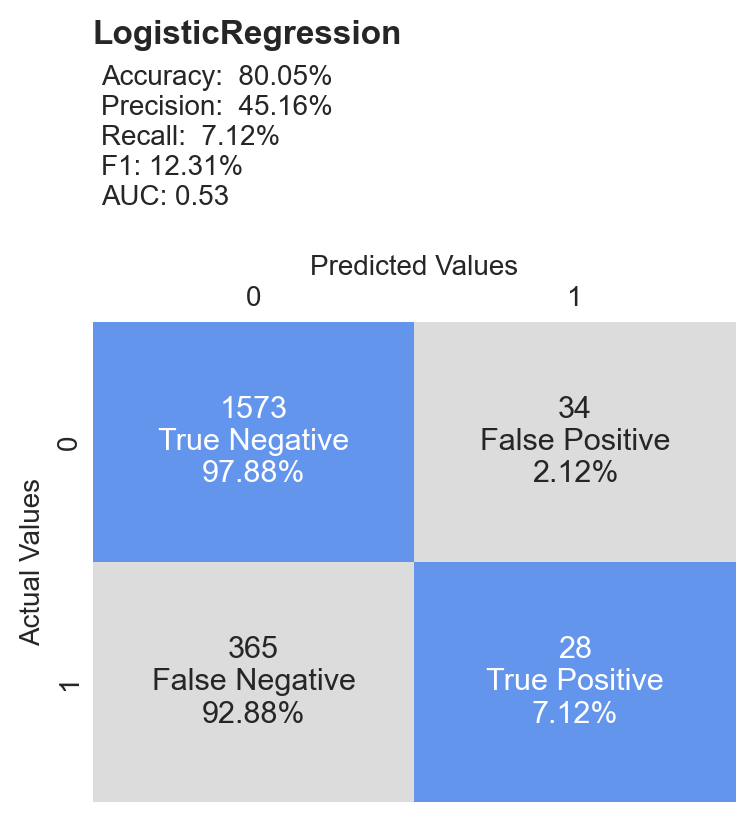

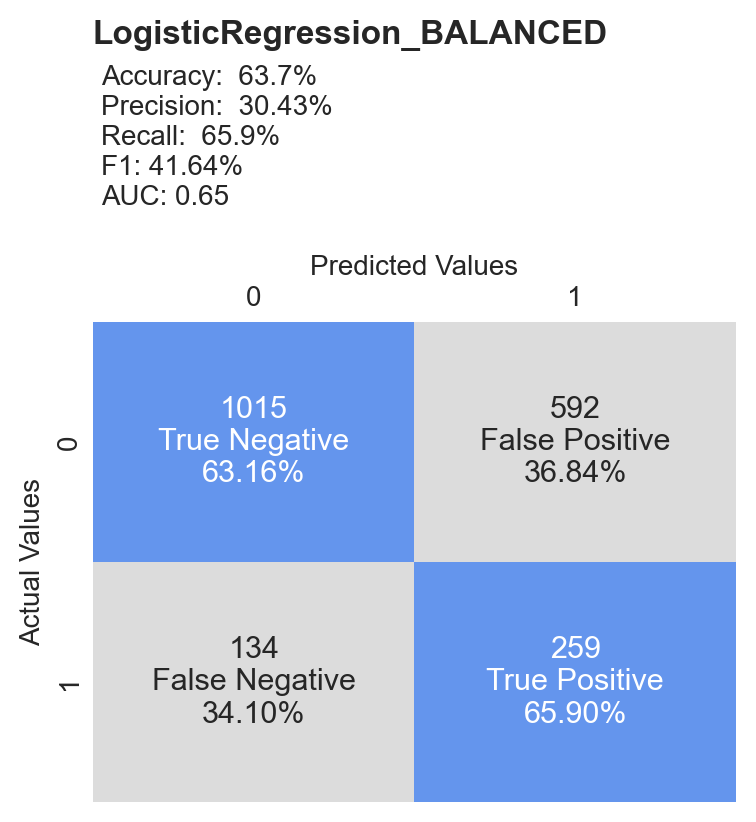

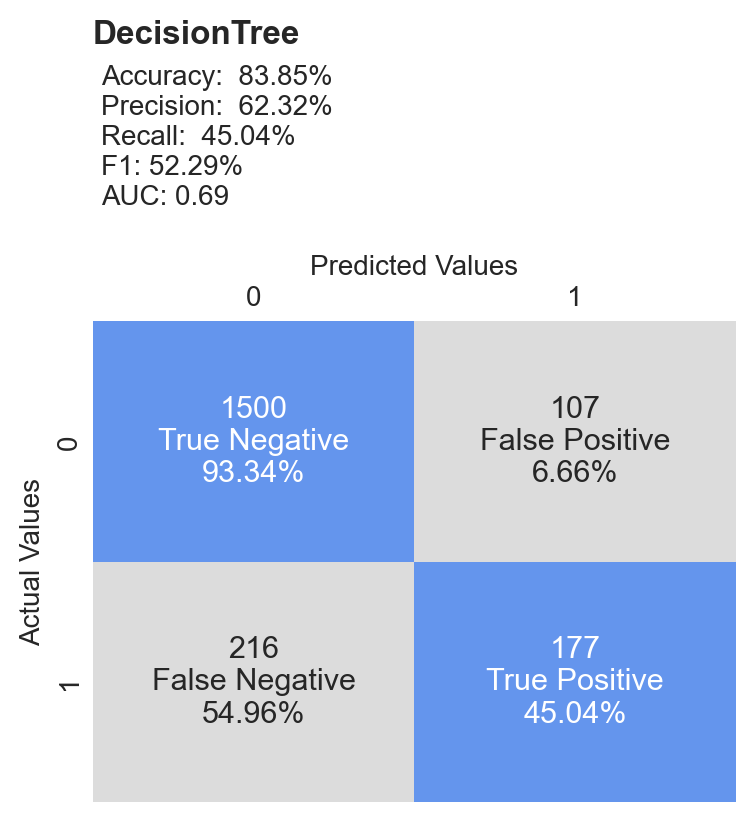

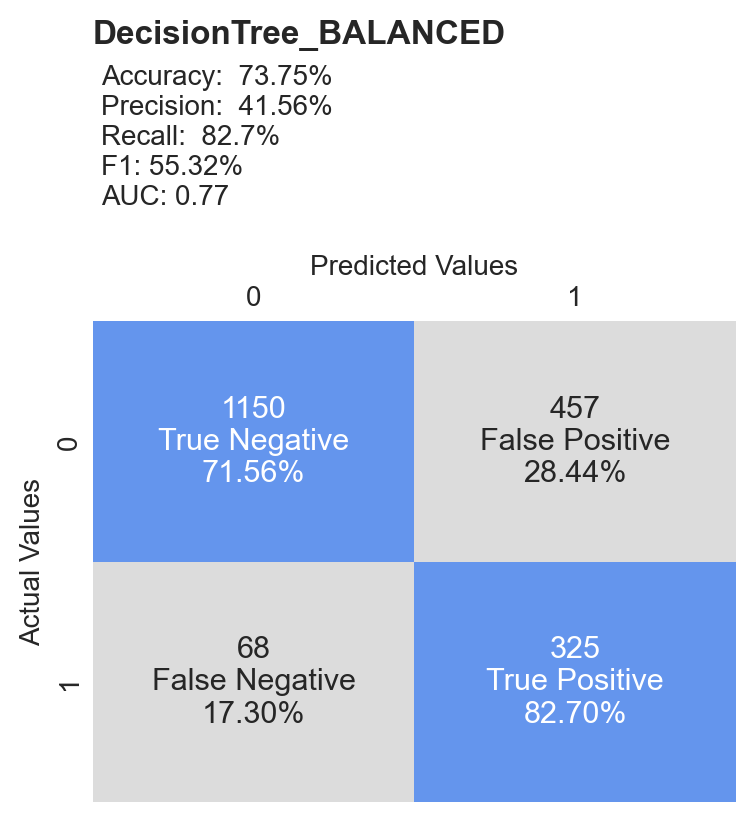

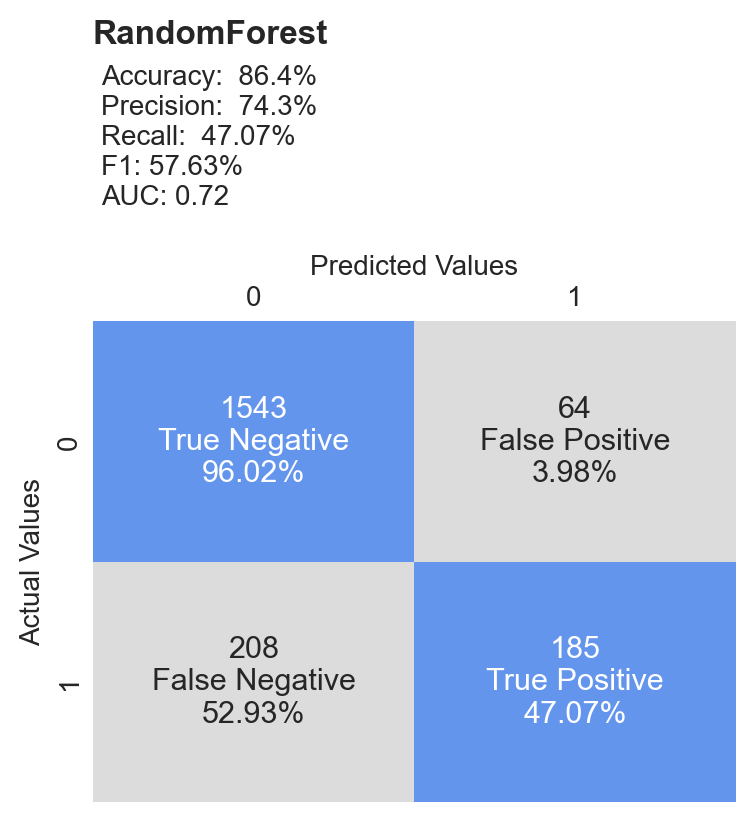

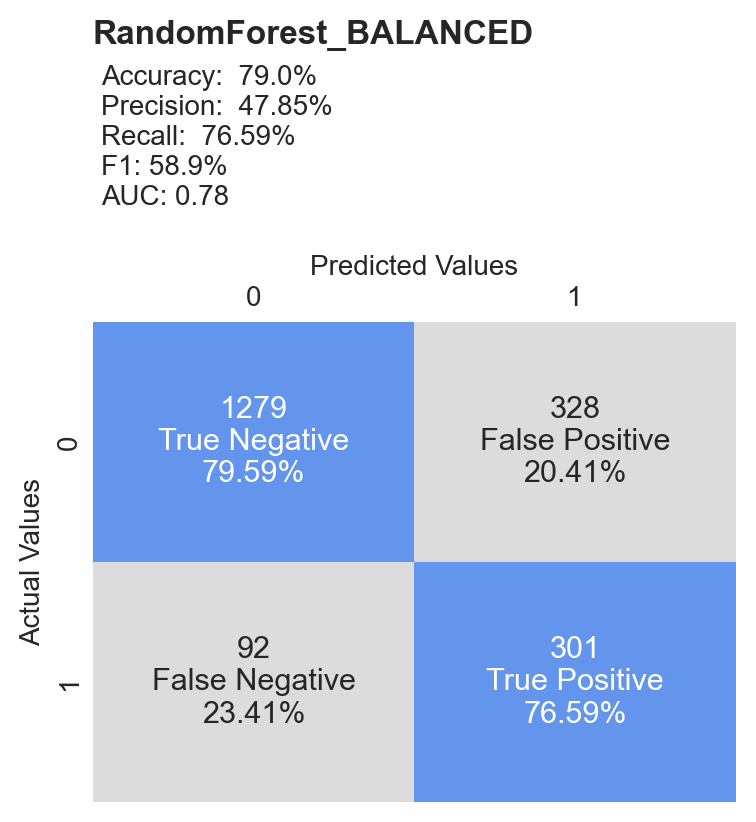

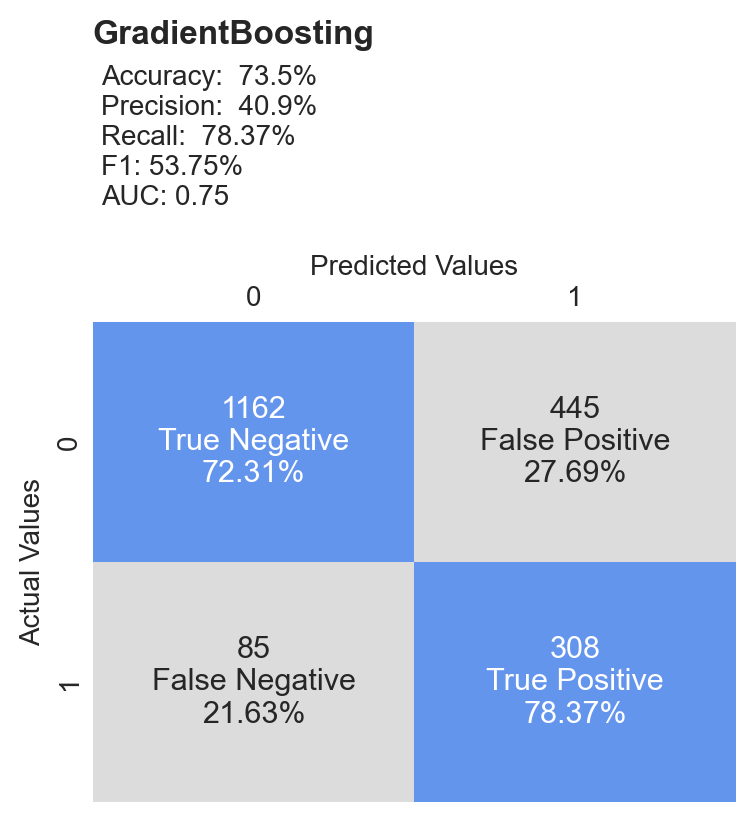

In [20]:
for model in models_tuned:
    report_scores_enhanced(model)